<a href="https://colab.research.google.com/github/Jingsai/CMPT300G/blob/master/handouts/Lecture7_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras

## Tackling Fashion MNIST With a CNN

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4431872/4422102 [==============================] - 0s 0us/step


In [24]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [4]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 30s 9ms/step - loss: 0.7017 - accuracy: 0.7581 - val_loss: 0.3498 - val_accuracy: 0.8682
Epoch 2/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4203 - accuracy: 0.8606 - val_loss: 0.3234 - val_accuracy: 0.8842
Epoch 3/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3558 - accuracy: 0.8812 - val_loss: 0.2992 - val_accuracy: 0.8936
Epoch 4/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3272 - accuracy: 0.8888 - val_loss: 0.2955 - val_accuracy: 0.8922
Epoch 5/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3070 - accuracy: 0.8948 - val_loss: 0.2890 - val_accuracy: 0.8966
Epoch 6/10
1719/1719 [==============================] - 15s 8ms/step - loss: 0.2852 - accuracy: 0.9040 - val_loss: 0.2904 - val_accuracy: 0.9026
Epoch 7/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2743 - accuracy: 0.9067 - val_loss: 0.2728 - val_ac

In [5]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.2502 - accuracy: 0.9163 - val_loss: 0.3031 - val_accuracy: 0.9030
Epoch 2/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2337 - accuracy: 0.9200 - val_loss: 0.3149 - val_accuracy: 0.9018
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2343 - accuracy: 0.9208 - val_loss: 0.3055 - val_accuracy: 0.9018
Epoch 4/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2210 - accuracy: 0.9246 - val_loss: 0.3131 - val_accuracy: 0.9044
Epoch 5/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2222 - accuracy: 0.9245 - val_loss: 0.3430 - val_accuracy: 0.8920
Epoch 6/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2288 - accuracy: 0.9234 - val_loss: 0.3026 - val_accuracy: 0.9106
Epoch 7/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2073 - accuracy: 0.9316 - val_loss: 0.3487 - val_a

In [6]:
score = model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.3823 - accuracy: 0.9032


## ResNet-34

In [ ]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)        7

## Using a Pretrained Model

In [3]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102981632/102967424 [==============================] - 2s 0us/step


In [5]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [6]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])

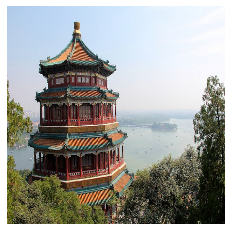

In [7]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


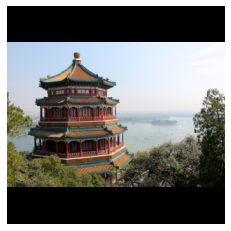

In [8]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

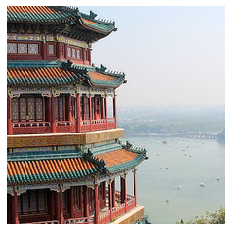

In [9]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

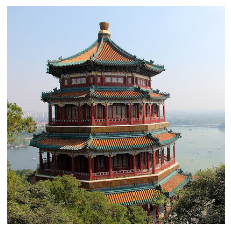

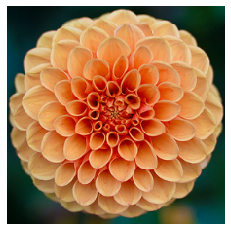

In [10]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [11]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [12]:
Y_proba.shape

(2, 1000)

In [13]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

49152/35363 [=========================================] - 0s 0us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



## Pretrained Models for Transfer Learning

In [14]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [15]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [16]:
info.splits["train"]

<tfds.core.SplitInfo num_examples=3670>

In [17]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [18]:
n_classes = info.features["label"].num_classes

In [19]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

**Warning:** TFDS's split API has evolved since the book was published. The [new split API](https://www.tensorflow.org/datasets/splits) (called S3) is much simpler to use:

In [20]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

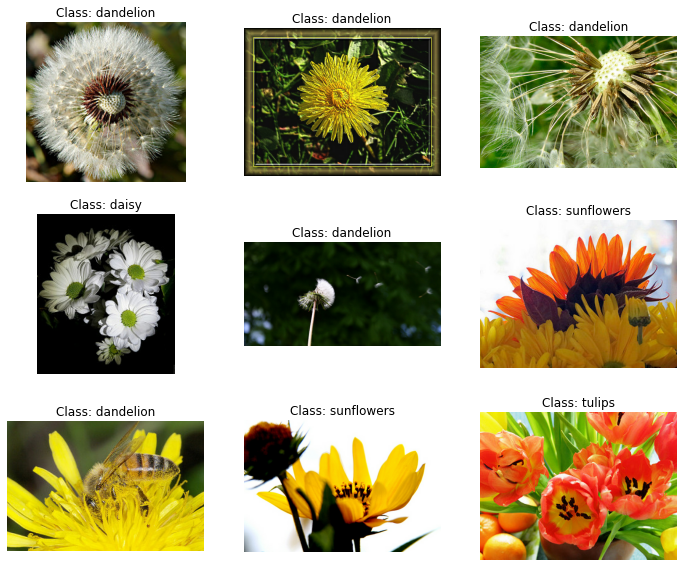

In [21]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

Basic preprocessing:

In [22]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

Slightly fancier preprocessing (but you could add much more data augmentation):

In [25]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

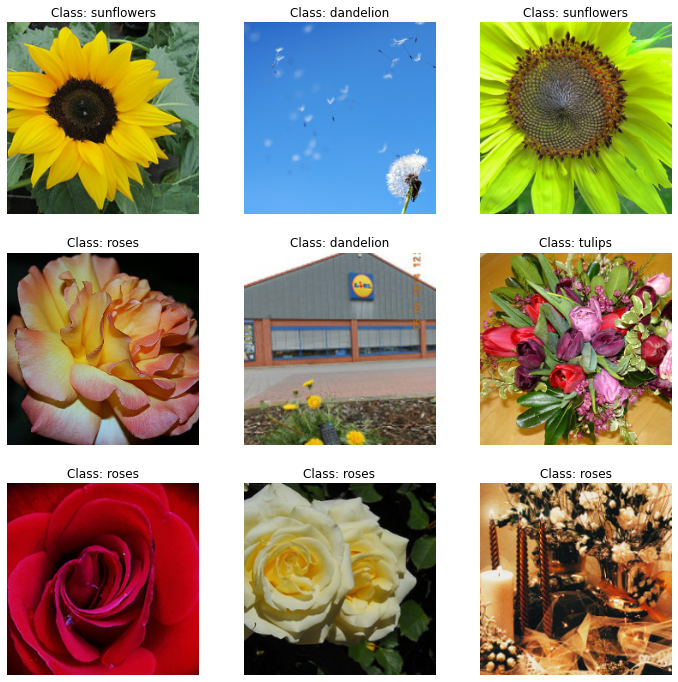

In [26]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

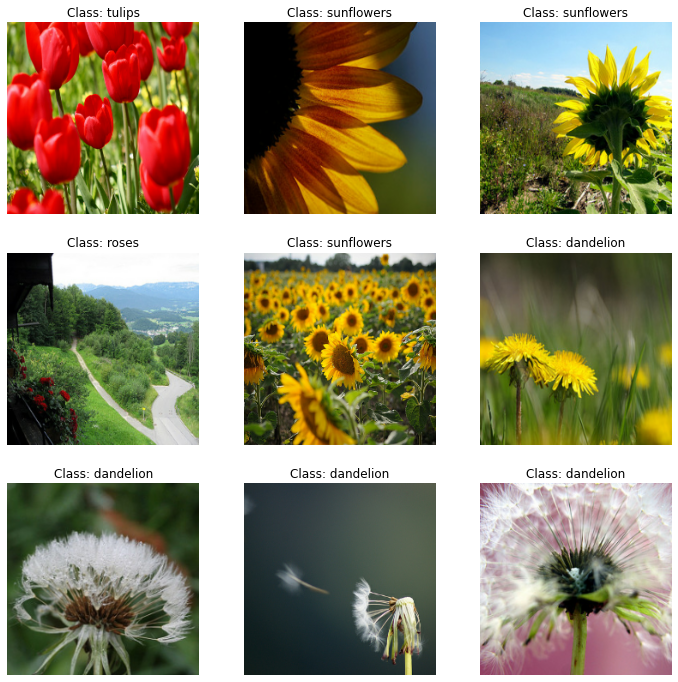

In [27]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [28]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83697664/83683744 [==============================] - 0s 0us/step


In [29]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_5
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_6
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_7
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_a

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 46s 532ms/step - loss: 0.6858 - accuracy: 0.7758 - val_loss: 1.7375 - val_accuracy: 0.7335
Epoch 2/5
86/86 [==============================] - 39s 450ms/step - loss: 0.3833 - accuracy: 0.8765 - val_loss: 1.2491 - val_accuracy: 0.7592
Epoch 3/5
86/86 [==============================] - 39s 450ms/step - loss: 0.3270 - accuracy: 0.8903 - val_loss: 1.2740 - val_accuracy: 0.7647
Epoch 4/5
86/86 [==============================] - 39s 451ms/step - loss: 0.2821 - accuracy: 0.9113 - val_loss: 1.1322 - val_accuracy: 0.7757
Epoch 5/5
86/86 [==============================] - 39s 452ms/step - loss: 0.2430 - accuracy: 0.9121 - val_loss: 1.5182 - val_accuracy: 0.7426


In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 172s 2s/step - loss: 0.2257 - accuracy: 0.9288 - val_loss: 0.6762 - val_accuracy: 0.8346
Epoch 2/40
86/86 [==============================] - 128s 1s/step - loss: 0.1124 - accuracy: 0.9640 - val_loss: 0.3932 - val_accuracy: 0.9154
Epoch 3/40
86/86 [==============================] - 129s 1s/step - loss: 0.0497 - accuracy: 0.9829 - val_loss: 0.2618 - val_accuracy: 0.9246
Epoch 4/40
86/86 [==============================] - 128s 1s/step - loss: 0.0425 - accuracy: 0.9836 - val_loss: 0.3446 - val_accuracy: 0.9136
Epoch 5/40
86/86 [==============================] - 128s 1s/step - loss: 0.0251 - accuracy: 0.9909 - val_loss: 0.2486 - val_accuracy: 0.9338
Epoch 6/40
86/86 [==============================] - 127s 1s/step - loss: 0.0142 - accuracy: 0.9949 - val_loss: 0.2324 - val_accuracy: 0.9430
Epoch 7/40
86/86 [==============================] - 128s 1s/step - loss: 0.0195 - accuracy: 0.9945 - val_loss: 0.2785 - val_accuracy: 0.9357
Epoch 8/40
86

# Classification and Localization

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

In [ ]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [ ]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
5/5 [==============================] - 134s 27s/step - loss: 1.3279 - dense_5_loss: 1.5696 - dense_6_loss: 0.3612 - dense_5_accuracy: 0.2625 - dense_6_accuracy: 0.2562
Epoch 2/2
5/5 [==============================] - 93s 19s/step - loss: 1.0533 - dense_5_loss: 1.2658 - dense_6_loss: 0.2035 - dense_5_accuracy: 0.5938 - dense_6_accuracy: 0.2000


## Mean Average Precision (mAP)

In [ ]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

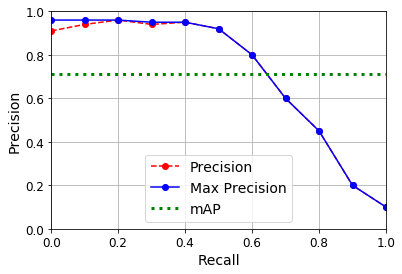

In [ ]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()

Transpose convolutions:

In [ ]:
tf.random.set_seed(42)
X = images_resized.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
output = conv_transpose(X)
output.shape

TensorShape([2, 449, 449, 5])

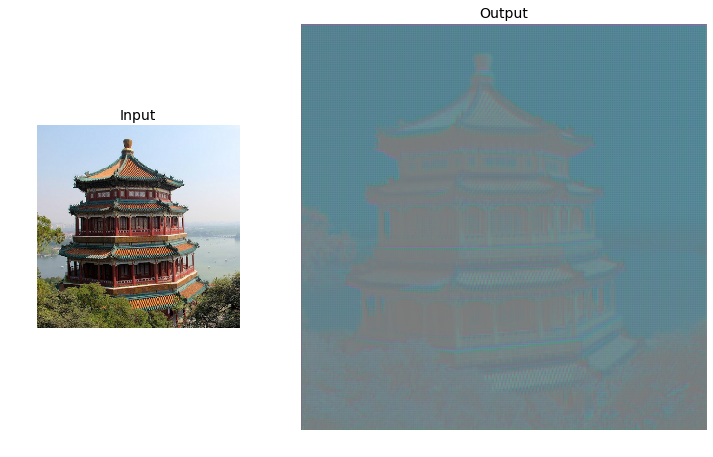

In [ ]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [ ]:
def upscale_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled = np.zeros((batch_size,
                         (height - 1) * stride + 2 * kernel_size - 1,
                         (width - 1) * stride + 2 * kernel_size - 1,
                         channels))
    upscaled[:,
             kernel_size - 1:(height - 1) * stride + kernel_size:stride,
             kernel_size - 1:(width - 1) * stride + kernel_size:stride,
             :] = images
    return upscaled

In [ ]:
upscaled = upscale_images(X, stride=2, kernel_size=3)
weights, biases = conv_transpose.weights
reversed_filters = np.flip(weights.numpy(), axis=[0, 1])
reversed_filters = np.transpose(reversed_filters, [0, 1, 3, 2])
manual_output = tf.nn.conv2d(upscaled, reversed_filters, strides=1, padding="VALID")

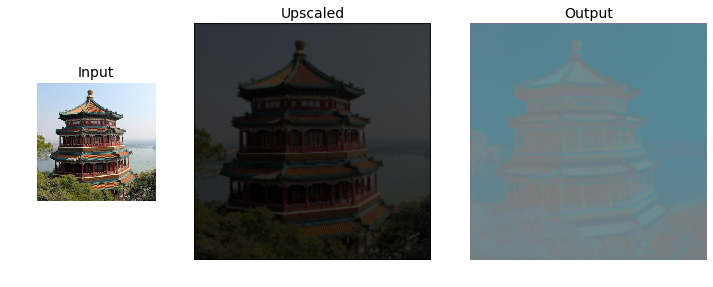

In [ ]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Upscaled", fontsize=14)
ax2.imshow(upscaled[0], interpolation="bicubic")
ax2.axis("off")
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Output", fontsize=14)
ax3.imshow(normalize(manual_output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax3.axis("off")
plt.show()

In [ ]:
np.allclose(output, manual_output.numpy(), atol=1e-7)

True